# Tutorial 6a - Introduction to Coatings

### July 2024

This tutorial demonstrates how to apply coatings on surfaces in Optiland and how to assess their impact. Coatings impact the nature of light as it propagates through an optical system. For example, uncoated optics can result in significant light loss in a lens, especially if many surfaces are present.

In this tutorial, we will analyze two coating types:

- "Simple" coatings
- "Fresnel" coatings

The details of each coating type will be explained in its respective section.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optiland import coatings, optic
from optiland.rays import PolarizationState

1. Lens with no coatings

Let's first define a simple doublet without coatings.

In [2]:
class Doublet(optic.Optic):
    def __init__(self):
        super().__init__()

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            radius=29.32908,
            thickness=0.7,
            material="N-BK7",
            is_stop=True,
        )
        self.add_surface(index=2, radius=-20.06842, thickness=0.032)
        self.add_surface(
            index=3,
            radius=-20.08770,
            thickness=0.5780,
            material=("SF2", "schott"),
        )
        self.add_surface(index=4, radius=-66.54774, thickness=47.3562)
        self.add_surface(index=5)

        self.set_aperture(aperture_type="imageFNO", value=8.0)

        self.set_field_type(field_type="angle")
        self.add_field(y=0.0)
        self.add_field(y=0.7)
        self.add_field(y=1.0)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

        self.update_paraxial()
        self.image_solve()

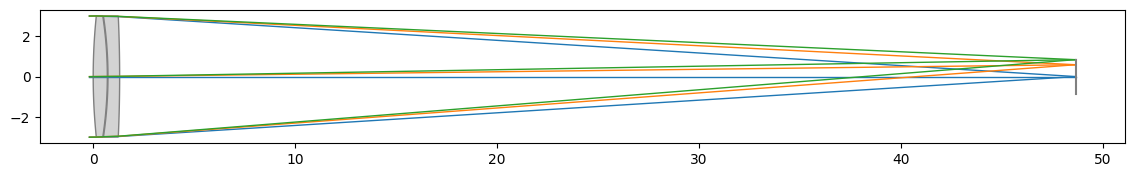

In [3]:
lens0 = Doublet()
lens0.draw(figsize=(14, 2))

We assess the intensity transmitted through the system by first tracing rays through the doublet, then analyzing the resulting ray intensity values at the image plane. This tutorial uses a similar approach to that shown in Tutorial 2a.

In [4]:
# trace rays through on-axis field point
rays = lens0.trace(Hx=0, Hy=0, wavelength=0.55, num_rays=256, distribution="uniform")

# take intensities of rays after ray tracing
intensity = rays.i

# compute average intensity per ray
avg_intensity = np.mean(intensity)

print(f"Average intensity per ray: {avg_intensity:.5f}")

Average intensity per ray: 0.99978


Let's also look at the histogram of all ray intensities:

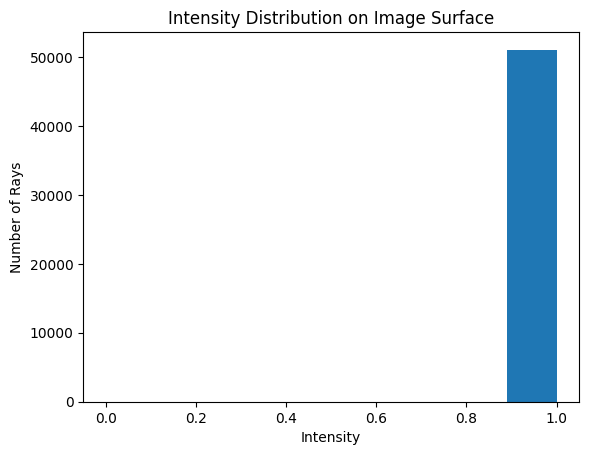

In [5]:
plt.hist(intensity, bins=np.linspace(0, 1, 10))
plt.xlabel("Intensity")
plt.ylabel("Number of Rays")
plt.title("Intensity Distribution on Image Surface")
plt.show()

As we can see, all rays have approximately the same intensity, which is 1. This is because no coatings have been applied to this lens, so no intensity is lost on any surface. This isn't particularly interesting.

2. Lens with "Simple" coating

Let's now apply a "Simple" coating, which assigns a fixed transmittance and reflectance factor for each surface. Any ray incident on the surface will experience the same transmittance and reflectance. Let's assume the following transmittance values for each surface in our doublet:

- Surface 1: 50%
- Surface 2: 60%
- Surface 3: 80%
- Surface 4: 90%

We will assume the reflectance is simply 100% minus the transmittance.

In [6]:
class DoubletSimpleCoating(optic.Optic):
    def __init__(self):
        super().__init__()

        # define coatings here
        coating1 = coatings.SimpleCoating(transmittance=0.5, reflectance=0.5)
        coating2 = coatings.SimpleCoating(transmittance=0.6, reflectance=0.4)
        coating3 = coatings.SimpleCoating(transmittance=0.8, reflectance=0.2)
        coating4 = coatings.SimpleCoating(transmittance=0.9, reflectance=0.1)

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)

        # add coating 1 to surface 1
        self.add_surface(
            index=1,
            radius=29.32908,
            thickness=0.7,
            material="N-BK7",
            is_stop=True,
            coating=coating1,
        )

        # add coating 2 to surface 2
        self.add_surface(index=2, radius=-20.06842, thickness=0.032, coating=coating2)

        # add coating 3 to surface 3
        self.add_surface(
            index=3,
            radius=-20.08770,
            thickness=0.5780,
            material=("SF2", "schott"),
            coating=coating3,
        )

        # add coating 4 to surface 4
        self.add_surface(index=4, radius=-66.54774, thickness=47.3562, coating=coating4)
        self.add_surface(index=5)

        self.set_aperture(aperture_type="imageFNO", value=8.0)

        self.set_field_type(field_type="angle")
        self.add_field(y=0.0)
        self.add_field(y=0.7)
        self.add_field(y=1.0)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

        self.update_paraxial()
        self.image_solve()

Let's now define our doublet with "Simple" coatings and perform the exact same analysis.

In [7]:
# define the lens0 with coatings
lens1 = DoubletSimpleCoating()

# trace rays through on-axis field point
rays = lens1.trace(Hx=0, Hy=0, wavelength=0.55, num_rays=256, distribution="uniform")

# take intensities of rays after ray tracing
intensity_simple = rays.i

# compute average intensity per ray
avg_intensity_simple = np.mean(intensity_simple)

print(f"Average intensity per ray: {avg_intensity_simple:.5f}")

Average intensity per ray: 0.21595


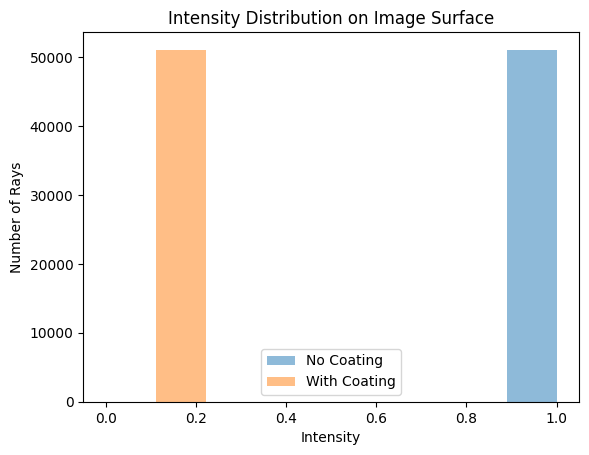

In [8]:
plt.hist(intensity, bins=np.linspace(0, 1, 10), label="No Coating", alpha=0.5)
plt.hist(intensity_simple, bins=np.linspace(0, 1, 10), label="With Coating", alpha=0.5)
plt.xlabel("Intensity")
plt.ylabel("Number of Rays")
plt.title("Intensity Distribution on Image Surface")
plt.legend()
plt.show()

The rays propagated through the lens with the coating now have an intensity value of ≈0.216, which is equal to 0.5 * 0.6 * 0.8 * 0.9, as expected. Compare this again to the nominal value of ≈1.0. Note that glass absorption causes a small transmission loss, which is on the order of 1e-4.

3. Lens with Fresnel coating

Let's define the same doublet, but this time with "Fresnel" coating on each surface. This uses the Fresnel equations to find the transmittance and reflectance coefficients and is equivalent to having uncoating lenses.

There are two key differences with respect to the last coating:

1. We specify coating='fresnel' for each interface surface
2. We must specify the polarization state of the incident light, which we choose as unpolarized light, which means we use a linear combination of two orthogonal polarization states.

In [9]:
class DoubletFresnelCoating(optic.Optic):
    def __init__(self):
        super().__init__()

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            radius=29.32908,
            thickness=0.7,
            material="N-BK7",
            is_stop=True,
            coating="fresnel",
        )  # <-- use fresnel coating
        self.add_surface(index=2, radius=-20.06842, thickness=0.032, coating="fresnel")
        self.add_surface(
            index=3,
            radius=-20.08770,
            thickness=0.5780,
            material=("SF2", "schott"),
            coating="fresnel",
        )
        self.add_surface(
            index=4,
            radius=-66.54774,
            thickness=47.3562,
            coating="fresnel",
        )
        self.add_surface(index=5)
        self.set_aperture(aperture_type="imageFNO", value=8.0)

        self.set_field_type(field_type="angle")
        self.add_field(y=0.0)
        self.add_field(y=0.7)
        self.add_field(y=1.0)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

        self.update_paraxial()
        self.image_solve()

        # Note the addition of the polarization state here!
        state = PolarizationState(is_polarized=False)
        self.set_polarization(state)

In [10]:
lens2 = DoubletFresnelCoating()

# trace rays through on-axis field point
rays = lens2.trace(Hx=0, Hy=0, wavelength=0.55, num_rays=256, distribution="uniform")

# take intensities of rays after ray tracing
intensity_fresnel = rays.i

# compute average intensity per ray
avg_intensity_fresnel = np.mean(intensity_fresnel)

print(f"Average intensity per ray: {avg_intensity_fresnel:.5f}")

Average intensity per ray: 0.80874


As before, let's plot the histogram of the intensity distribution on the image surface.

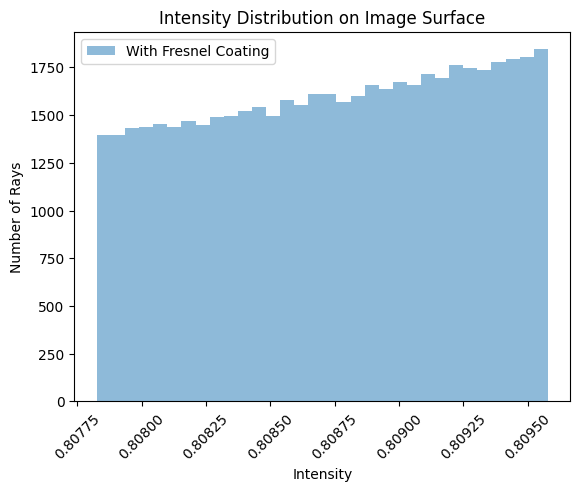

In [11]:
plt.hist(intensity_fresnel, bins=32, label="With Fresnel Coating", alpha=0.5)
plt.xlabel("Intensity")
plt.ylabel("Number of Rays")
plt.title("Intensity Distribution on Image Surface")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Clearly, we see a range in transmission through the lens. Let's also look at the transmission as a function of position in the aperture stop.

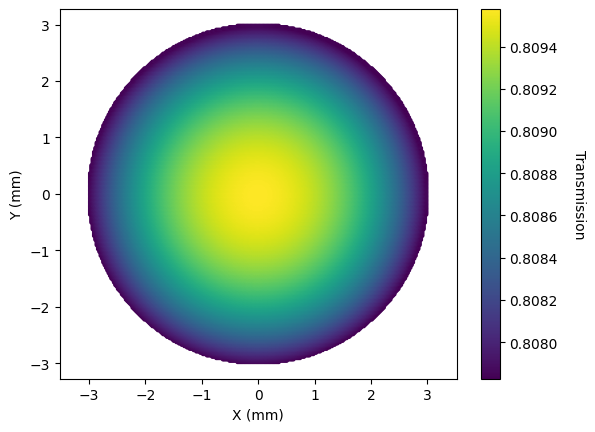

In [12]:
# stop is on first surface --> index 1
x_stop = lens2.surface_group.x[1, :]
y_stop = lens2.surface_group.y[1, :]

plt.scatter(x_stop, y_stop, c=intensity_fresnel, s=5)
plt.axis("equal")
cbar = plt.colorbar()
cbar.set_label("Transmission", rotation=270, labelpad=20)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.show()

First, we see that the uncoated optic has a transmission of near 80%. Secondly, while the effect is small, we can clearly see that at smaller angles of incidence, i.e., near the center, the transmission is a maximum. This is consistent with the Fresnel equations for unpolarized light.

Conclusions:

- This tutorial introduced the concept of coatings in Optiland.
- The "SimpleCoating" class was demonstrated, which simply assigns a fixed intensity loss during ray interaction with a surface.
- The "FresnelCoating" was also introduced, which enables calculation of the effect of e.g., transmission impact due to uncoated glass in lens systems.

The following tutorials will elaborate on the concepts of coatings and polarization in Optiland.